# Analysis of the Incident Characteristics
## Load, Clean and Enrich the Data

In [43]:
# Import and configuration
import chart_config
from functools import reduce
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from config import *

In [2]:
# Load clean data from CSV
raw_data = pd.read_csv(incidents_clean_data_path)
# For the purposes of this analysis we don't care about incidents with no characteristics
total_count = len(raw_data.index)
raw_data = raw_data.dropna(how='any',subset=['Incident Info']).reset_index(drop=True)
print(f'There were {total_count - len(raw_data.index)} out of {total_count} incidents with no characteristics')
raw_data.head()

There were 326 out of 239677 incidents with no characteristics


,Year,State Name,Number of Killed,Number of Injured,Incident Info,Latitude,Longitude,Participant Age,Participant Age Group,Participant Gender,Participant Relationship,Participant Status,Participant Type,State Abbr
0,2013,Pennsylvania,0,4,Shot - Wounded/Injured||Mass Shooting (4+ vict...,40.3467,-79.8559,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,PA
1,2013,California,1,3,"Shot - Wounded/Injured||Shot - Dead (murder, a...",33.9090,-118.3330,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,CA
2,2013,Ohio,1,3,"Shot - Wounded/Injured||Shot - Dead (murder, a...",41.4455,-82.1377,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,OH
3,2013,Colorado,4,0,"Shot - Dead (murder, accidental, suicide)||Off...",39.6518,-104.8020,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,CO
4,2013,North Carolina,2,2,"Shot - Wounded/Injured||Shot - Dead (murder, a...",36.1140,-79.9569,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,NC


In [3]:
# There are several columns that we don't use for this analysis so lets drop them
clean_data = raw_data.drop(columns=[
    'State Name',
    'Participant Age', 
    'Participant Age Group', 
    'Participant Gender',
    'Participant Relationship',
    'Participant Status',
    'Participant Type'
])
clean_data.head()

,Year,Number of Killed,Number of Injured,Incident Info,Latitude,Longitude,State Abbr
0,2013,0,4,Shot - Wounded/Injured||Mass Shooting (4+ vict...,40.3467,-79.8559,PA
1,2013,1,3,"Shot - Wounded/Injured||Shot - Dead (murder, a...",33.9090,-118.3330,CA
2,2013,1,3,"Shot - Wounded/Injured||Shot - Dead (murder, a...",41.4455,-82.1377,OH
3,2013,4,0,"Shot - Dead (murder, accidental, suicide)||Off...",39.6518,-104.8020,CO
4,2013,2,2,"Shot - Wounded/Injured||Shot - Dead (murder, a...",36.1140,-79.9569,NC


In [4]:
# First lets split incident charactericis field and keep values in the sets (for faster operations)
empty_value_set = {''}
split_inc_info_data = clean_data.copy()
split_inc_info_data['Incident Info'] = split_inc_info_data['Incident Info'].apply(lambda x: set(x.split('|')).difference(empty_value_set))
split_inc_info_data.head()

,Year,Number of Killed,Number of Injured,Incident Info,Latitude,Longitude,State Abbr
0,2013,0,4,{Mass Shooting (4+ victims injured or killed e...,40.3467,-79.8559,PA
1,2013,1,3,"{Shot - Dead (murder, accidental, suicide), Sh...",33.9090,-118.3330,CA
2,2013,1,3,"{Shot - Dead (murder, accidental, suicide), Sh...",41.4455,-82.1377,OH
3,2013,4,0,{Officer Involved Shooting - subject/suspect/p...,39.6518,-104.8020,CO
4,2013,2,2,"{Shot - Dead (murder, accidental, suicide), Sh...",36.1140,-79.9569,NC


In [5]:
# Lets first take a look at all existing categories of the incidents (one incident can belong to multiple categories)
distinct_categories = reduce(lambda x,y: x.union(y), split_inc_info_data['Incident Info'])
print(f'There are {len(distinct_categories)} unique categories')
distinct_categories

There are 109 unique categories


{'ATF/LE Confiscation/Raid/Arrest',
 'Accidental Shooting',
 'Accidental Shooting - Death',
 'Accidental Shooting - Injury',
 'Accidental Shooting at a Business',
 'Accidental/Negligent Discharge',
 'Animal shot/killed',
 'Armed robbery with injury/death and/or evidence of DGU found',
 'Assault weapon (AR-15, AK-47, and ALL variants defined by law enforcement)',
 'Attempted Murder/Suicide (one variable unsuccessful)',
 'BB/Pellet/Replica gun',
 'Bar/club incident - in or around establishment',
 'Brandishing/flourishing/open carry/lost/found',
 'Car-jacking',
 'Child Involved Incident',
 'Child injured (not child shooter)',
 'Child injured by child',
 'Child injured self',
 'Child killed (not child shooter)',
 'Child killed by child',
 'Child killed self',
 'Child picked up & fired gun',
 'Child with gun - no shots fired',
 'Cleaning gun',
 'Concealed Carry License - Perpetrator',
 'Concealed Carry License - Victim',
 'Criminal act with stolen gun',
 'Defensive Use',
 'Defensive Use - C

## General Statistics

In [108]:
# Now lets take a look at the statistics for each category
category_related_data = {
    'Category': [],
    'Number of Incidents': [],
    'Total Killed': [],
    'Total Injured': []
}
for category in distinct_categories:
    category_related_data['Category'].append(category)
    filter_series = split_inc_info_data['Incident Info'].apply(lambda x: category in x)
    category_related_incidents = split_inc_info_data.loc[filter_series,:]
    category_related_data['Number of Incidents'].append(len(category_related_incidents.index))
    category_related_data['Total Killed'].append(category_related_incidents['Number of Killed'].sum())
    category_related_data['Total Injured'].append(category_related_incidents['Number of Injured'].sum())
cat_data = pd.DataFrame(category_related_data).sort_values('Number of Incidents', ascending=False).reset_index(drop=True)
# There is a long category 'Under the influence of alcohol or drugs (only applies to the subject/suspect/perpetrator )'
# Lets shorten it a bit so it will look nicer on the chart
cat_data.loc[cat_data['Category'] == 'Under the influence of alcohol or drugs (only applies to the subject/suspect/perpetrator )', 'Category'] = 'Under the influence of alcohol or drugs'
cat_data.loc[cat_data['Category']]
cat_data.head()

,Category,Number of Incidents,Total Killed,Total Injured
0,Shot - Wounded/Injured,93926,9958,113987
1,"Shot - Dead (murder, accidental, suicide)",53409,59794,12147
2,Non-Shooting Incident,44837,19,1887
3,Shots Fired - No Injuries,35750,192,985
4,Possession (gun(s) found during commission of ...,30863,2232,5822


In [109]:
# Lets drop some generic categories (these will be present in most of the categories)
non_gen_cat_data = cat_data.iloc[4:].reset_index(drop=True)
non_gen_cat_data.head()

,Category,Number of Incidents,Total Killed,Total Injured
0,Possession (gun(s) found during commission of ...,30863,2232,5822
1,Armed robbery with injury/death and/or evidenc...,19723,3011,9061
2,Brandishing/flourishing/open carry/lost/found,19017,1502,3089
3,ATF/LE Confiscation/Raid/Arrest,17991,602,1275
4,Officer Involved Incident,17988,6509,6490


In [110]:
def multiliner(long_str):
    lines = []
    line = ''
    words = long_str.split()
    for word in words:
        line = f'{line}{word} '
        if len(line) > 30:
            lines.append(line)
            line = ''
    if line:
        lines.append(line)
    return '\n'.join(lines)

## Top 20 Categories by Number of Incidents

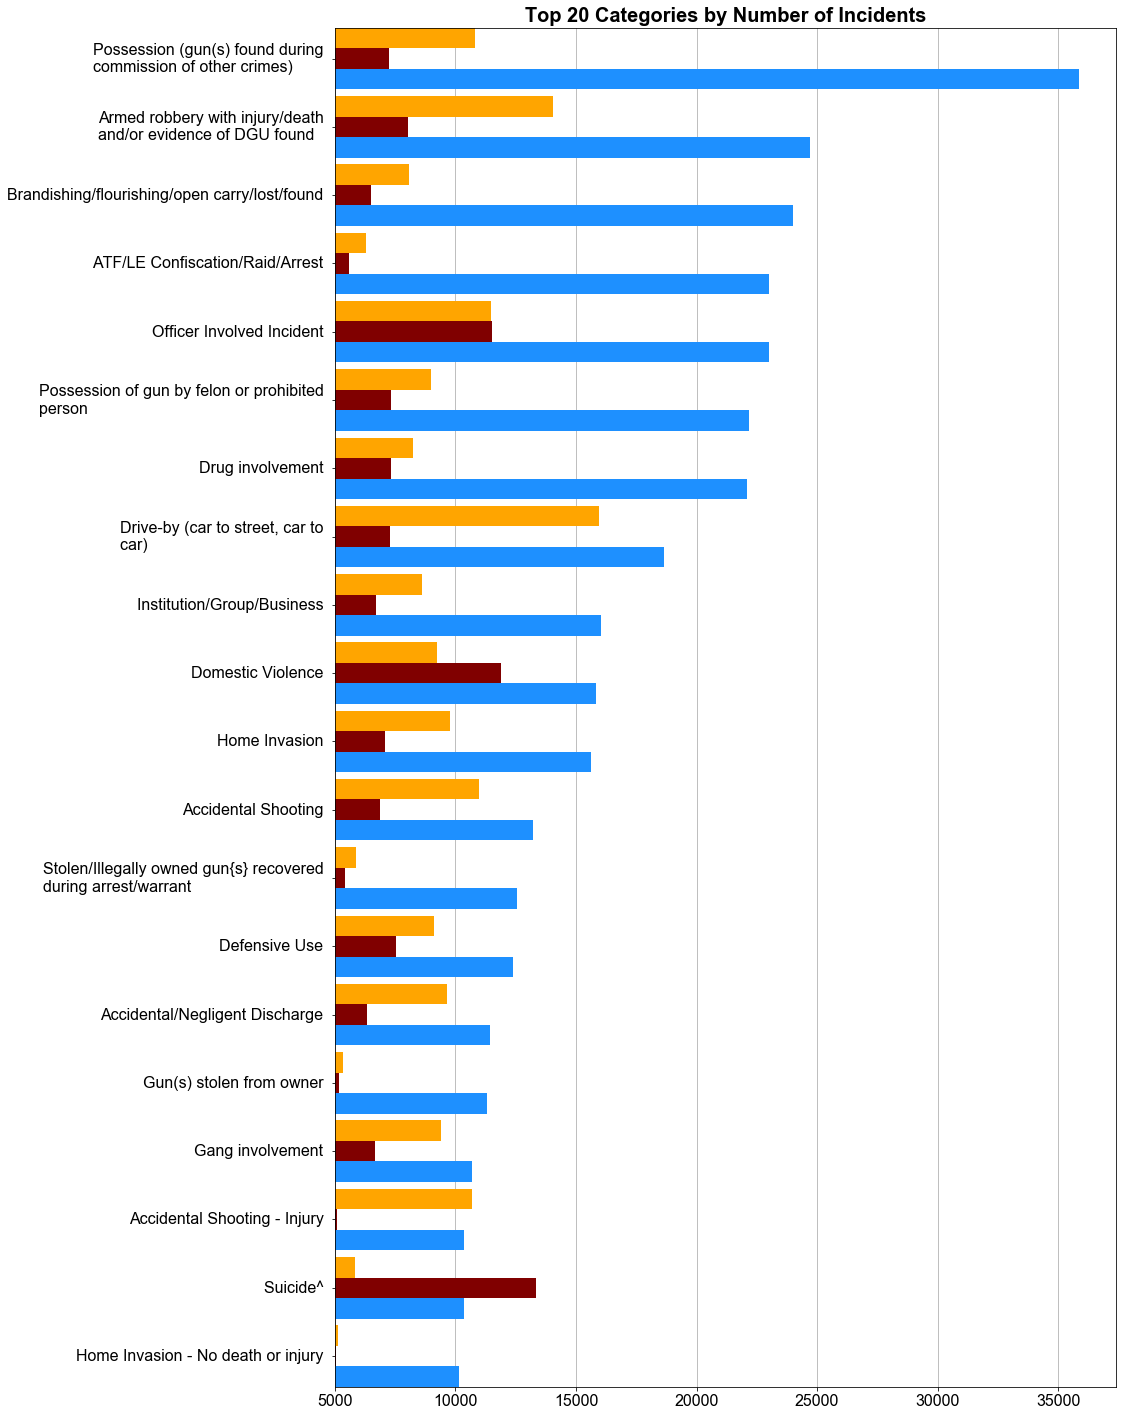

In [123]:
top_n_inc_data = non_gen_cat_data.head(20).iloc[::-1].reset_index(drop=True)
bar_width = 0.3
fig,ax = plt.subplots(figsize=(14,25))
n_inc = ax.barh(top_n_inc_data.index, top_n_inc_data['Number of Incidents'], bar_width, color='dodgerblue')
n_kil = ax.barh(top_n_inc_data.index + bar_width, top_n_inc_data['Total Killed'], bar_width, color='maroon')
n_inj = ax.barh(top_n_inc_data.index + 2 * bar_width, top_n_inc_data['Total Injured'], bar_width, color='orange')
ax.set_title('Top 20 Categories by Number of Incidents', fontdict=chart_config.title_font)
ax.set_yticks(top_n_inc_data.index + bar_width)
ax.set_yticklabels(top_n_inc_data['Category'].apply(multiliner),fontdict=chart_config.axis_font, wrap=True, ma='left',va='center')
ax.set_xticklabels([5000 * i for i in range(1,8)], fontdict=chart_config.axis_font)
ax.set_ylim(-0.15, 19.75)
ax.grid(True, axis='x')
ax.set_axisbelow(True)
plt.show()

## Top 20 Categories by Number of Killed

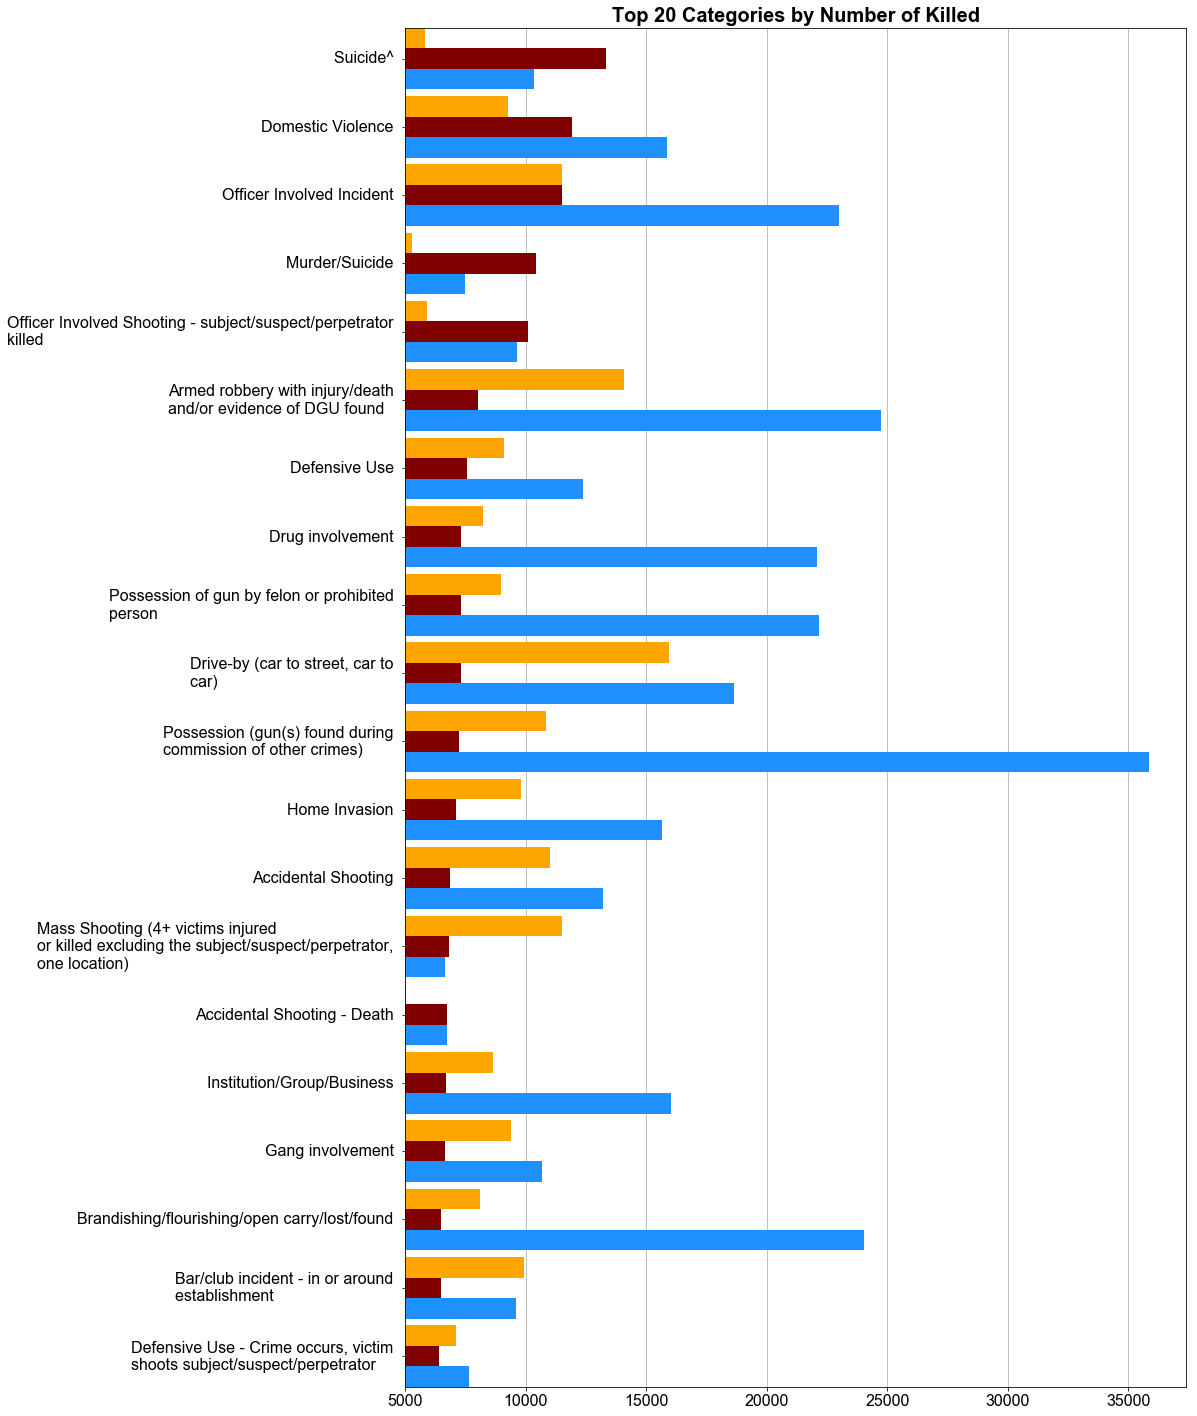

In [121]:
top_n_kil_data = non_gen_cat_data.sort_values('Total Killed', ascending=False).head(20).iloc[::-1].reset_index(drop=True)
bar_width = 0.3
fig,ax = plt.subplots(figsize=(14,25))
n_inc = ax.barh(top_n_kil_data.index, top_n_kil_data['Number of Incidents'], bar_width, color='dodgerblue')
n_kil = ax.barh(top_n_kil_data.index + bar_width, top_n_kil_data['Total Killed'], bar_width, color='maroon')
n_inj = ax.barh(top_n_kil_data.index + 2 * bar_width, top_n_kil_data['Total Injured'], bar_width, color='orange')
ax.set_title('Top 20 Categories by Number of Killed', fontdict=chart_config.title_font)
ax.set_yticks(top_n_kil_data.index + bar_width)
ax.set_yticklabels(top_n_kil_data['Category'].apply(multiliner),fontdict=chart_config.axis_font, wrap=True, ma='left',va='center')
ax.set_xticklabels([5000 * i for i in range(1,8)], fontdict=chart_config.axis_font)
ax.set_ylim(-0.15, 19.75)
ax.grid(True, axis='x')
ax.set_axisbelow(True)
plt.show()